In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve

shape of moons:  (10000, 2)


(-0.14344621857735884,
 0.14497895728580568,
 -0.2527396234091284,
 0.2517003755752799)

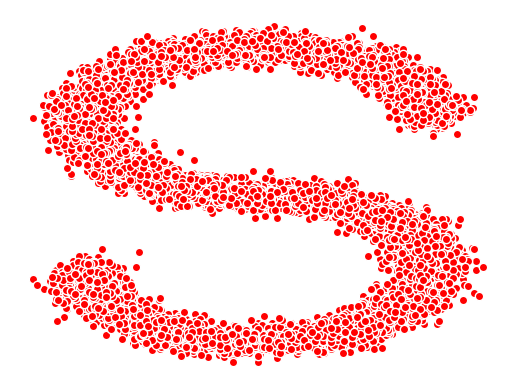

In [10]:
s_curve, _ = make_s_curve(10 ** 4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
print("shape of moons: ", np.shape(s_curve))
data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')
ax.axis('off')

In [11]:
import mindspore as ms
ms.context.set_context(mode=ms.GRAPH_MODE)

In [12]:
num_steps = 100

betas = ms.ops.linspace(ms.Tensor(-6).astype(ms.float32), ms.Tensor(6).astype(ms.float32), num_steps)
betas = ms.ops.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_prod = ms.ops.cumprod(alphas, 0)
alphas_prod_p = ms.ops.concat([ms.Tensor([1]).astype(ms.float32), alphas_prod[:-1]], 0)
alphas_bar_sqrt = ms.ops.sqrt(alphas_prod)
one_minus_alphas_bar_log = ms.ops.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = ms.ops.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape

print(betas.shape)

(100,)


In [13]:
def q_x(x_0, t):
    stdnormal = ms.ops.StandardNormal(seed=2)
    noise = stdnormal(x_0.shape)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [14]:
dataset = ms.Tensor(s_curve).astype(ms.float32)

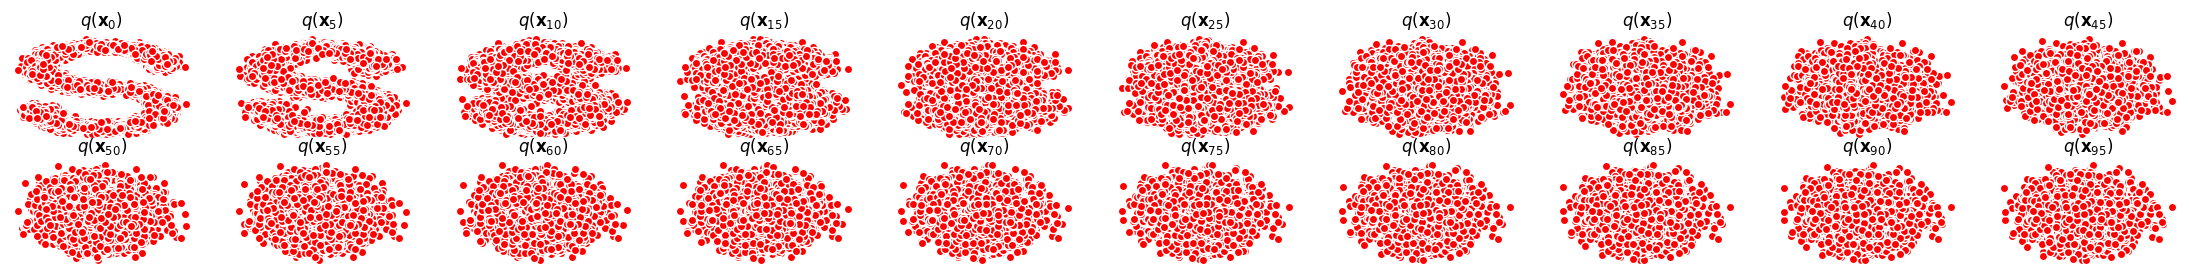

In [7]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, ms.Tensor([i * num_steps // num_shows]))
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{' + str(i * num_steps // num_shows) + '})$')

In [15]:
import mindspore.nn as nn


class MLPDiffusion(nn.Cell):

    def __init__(self, n_steps, num_uints=128):
        super(MLPDiffusion, self).__init__()
        self.linears = nn.CellList(
            [
                nn.Dense(2, num_uints),
                nn.ReLU(),
                nn.Dense(num_uints, num_uints),
                nn.ReLU(),
                nn.Dense(num_uints, num_uints),
                nn.ReLU(),
                nn.Dense(num_uints, 2),
            ]
        )
        self.step_embeddings = nn.CellList(
            [
                nn.Embedding(n_steps, num_uints),
                nn.Embedding(n_steps, num_uints),
                nn.Embedding(n_steps, num_uints),
            ]
        )

    def construct(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)
        return x

In [16]:
from time import time


def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    uniform_int = ms.ops.UniformInt(seed=int(time()))
    t = uniform_int((batch_size // 2,), ms.Tensor(0).astype(ms.int32), ms.Tensor(n_steps).astype(ms.int32))
    t = ms.ops.concat([t, n_steps - 1 - t], axis=0)
    expand_dims = ms.ops.ExpandDims()
    t = expand_dims(t, -1)

    a = alphas_bar_sqrt[t]

    am1 = one_minus_alphas_bar_sqrt[t]
    stdnormal = ms.ops.StandardNormal(seed=int(time()))
    e = stdnormal(x_0.shape)

    x = x_0 * a + e * am1

    output = model(x, t.squeeze(-1))
    return (e - output).square().mean()

In [17]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    stdnormal = ms.ops.StandardNormal(seed=int(time()))
    cur_x = stdnormal(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq


def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    stdnormal = ms.ops.StandardNormal(seed=int(time()))
    t = ms.Tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    z = stdnormal(x.shape)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [18]:
import mindspore.dataset as ds

0.66432256
0.47960207
0.19041975
0.6337874
0.6527602
0.49821278
0.19048926
0.1824336
0.37324524
0.7286591
0.4948848
0.32990223
0.32679632
0.14095828
0.27472958
0.32301342
0.7044566
0.30516693
0.59861714
0.5362394
0.22598238


C:\Users\XIANAI\AppData\Local\Temp\ipykernel_23960\3739944218.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


0.2619592
0.392804
0.576993
0.17412801
0.74914384
0.26192117
0.26514173
0.28102723
0.16683558
0.42676273
0.16443168
0.35518685
0.78188616
0.18683584
0.61146855
0.5004515
0.22222124
0.16995141
0.40361762


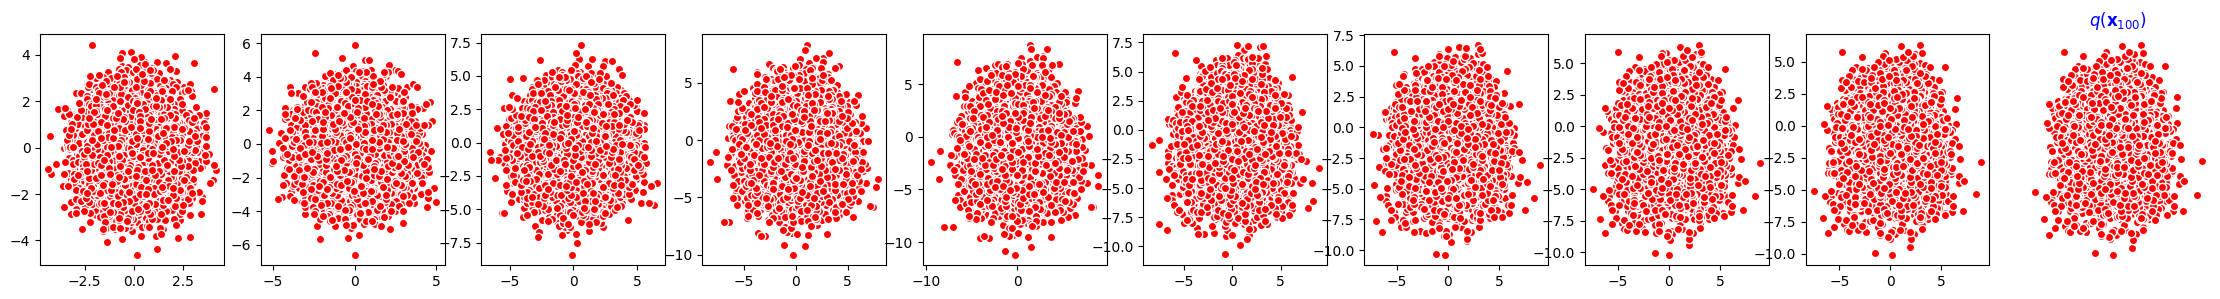

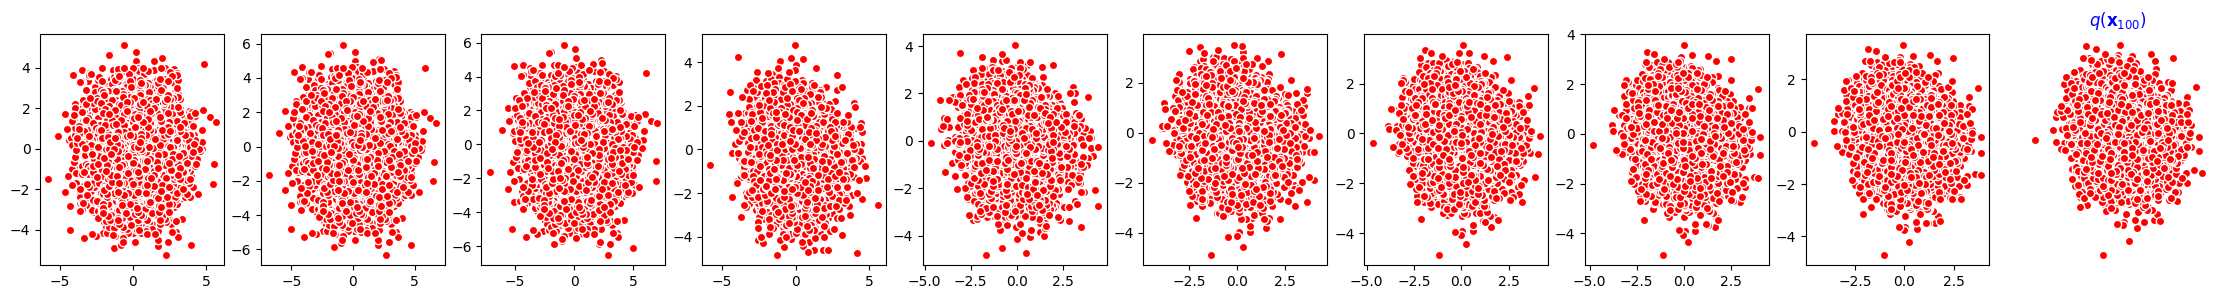

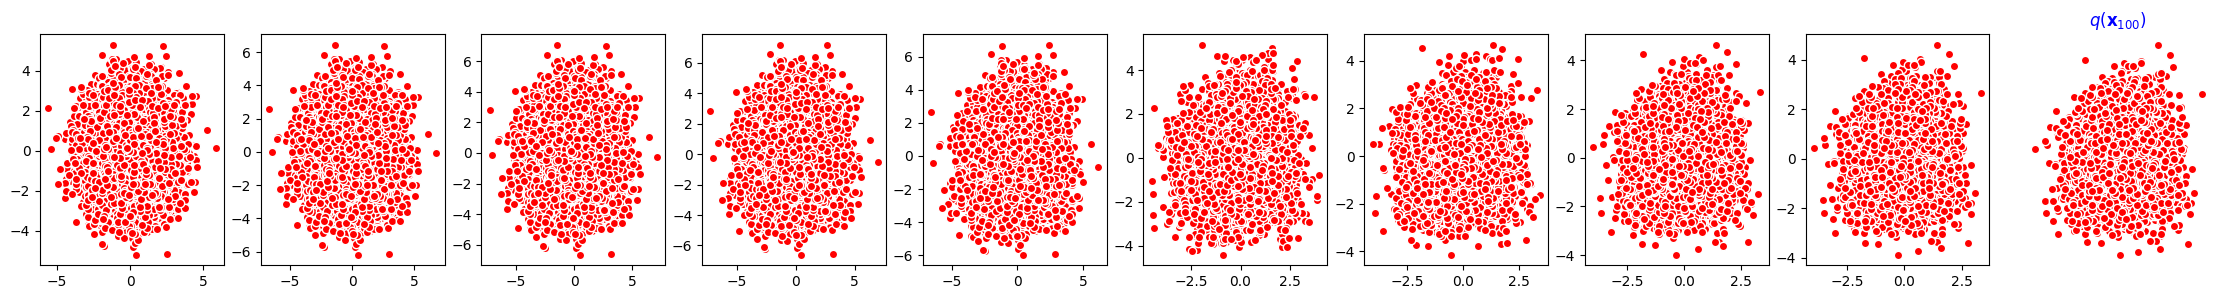

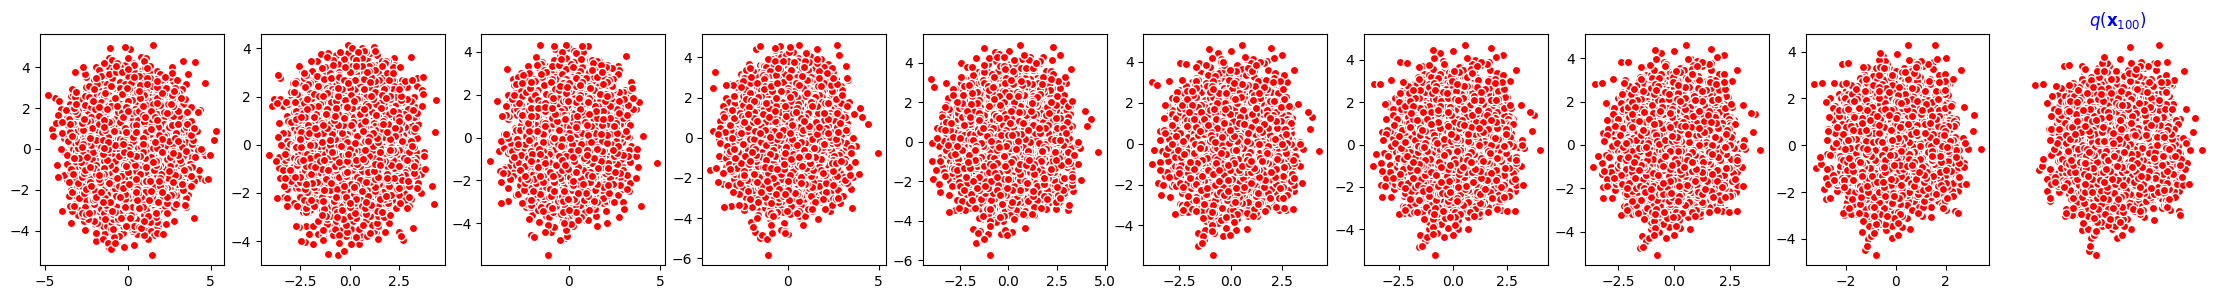

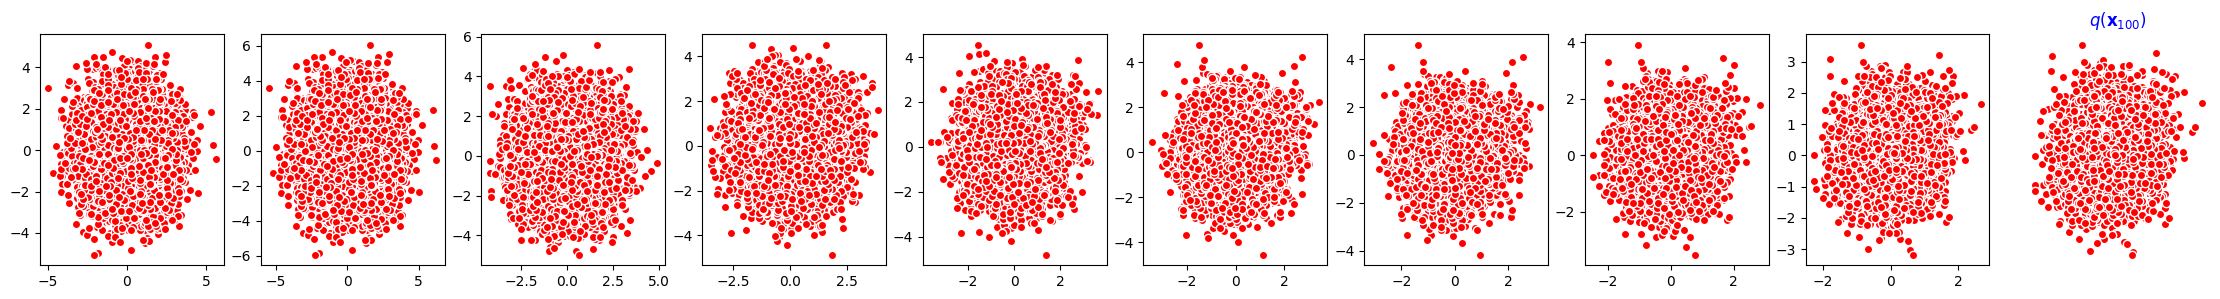

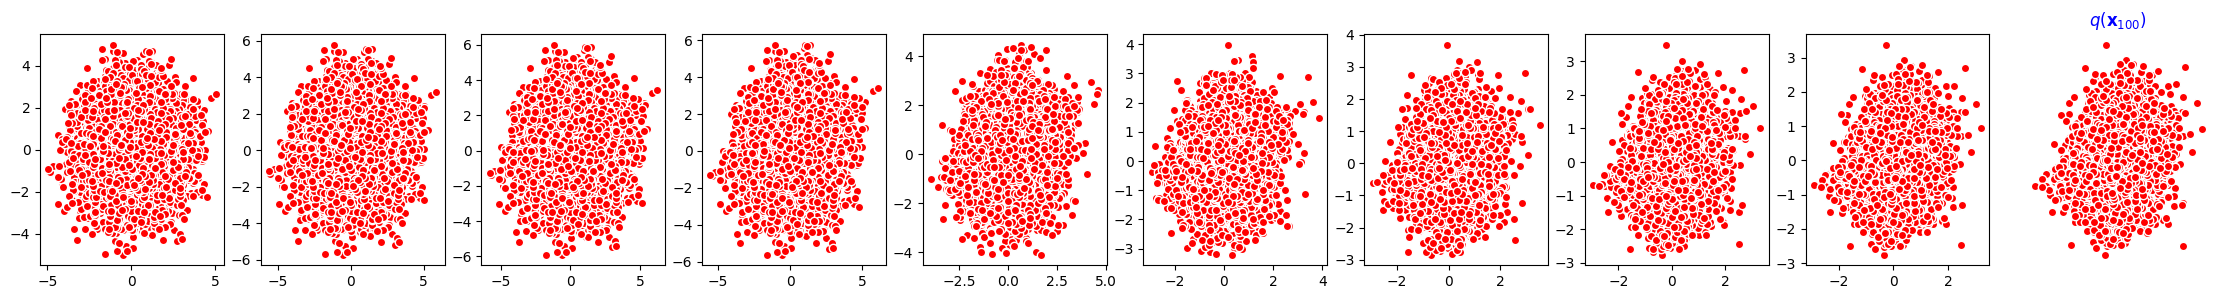

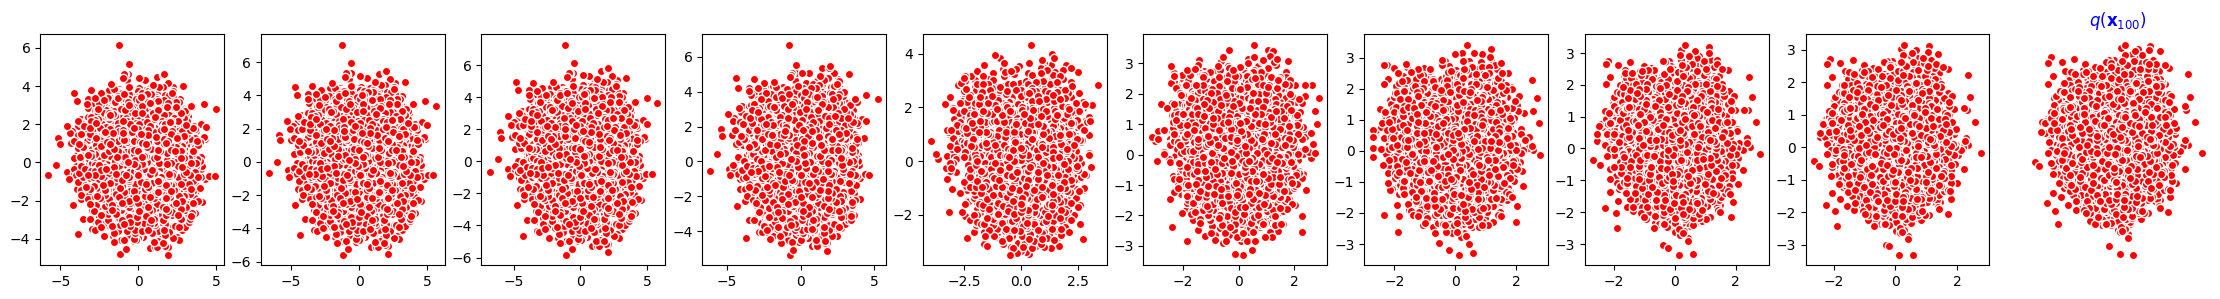

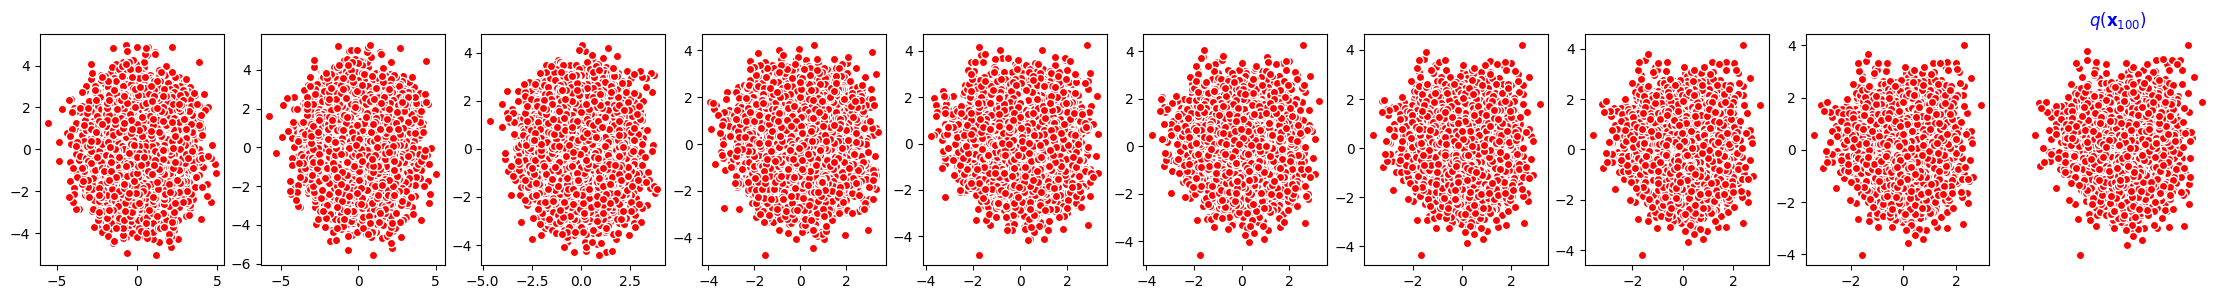

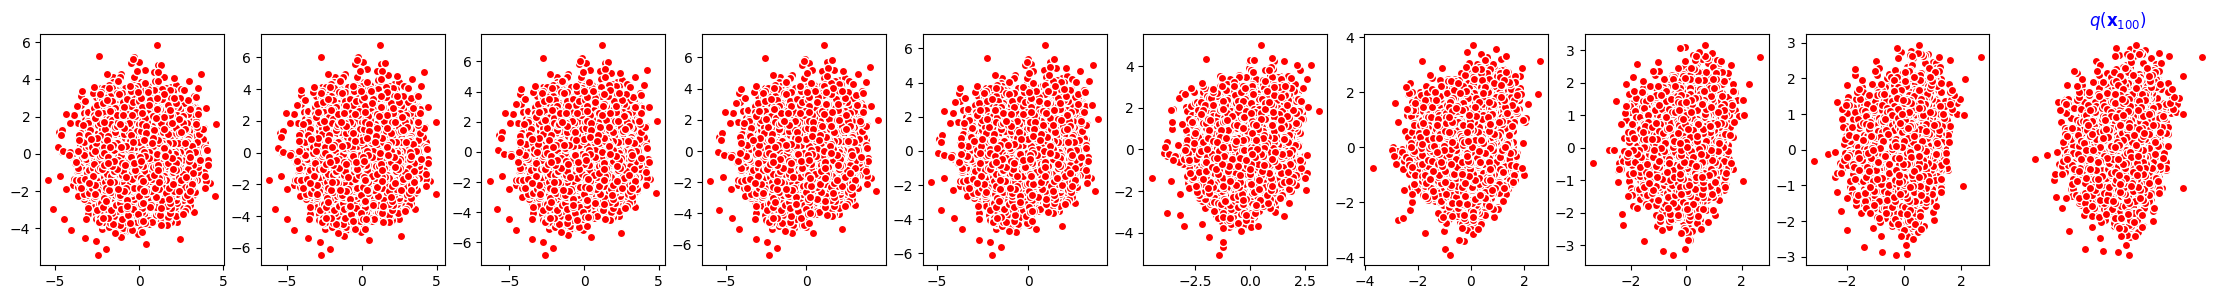

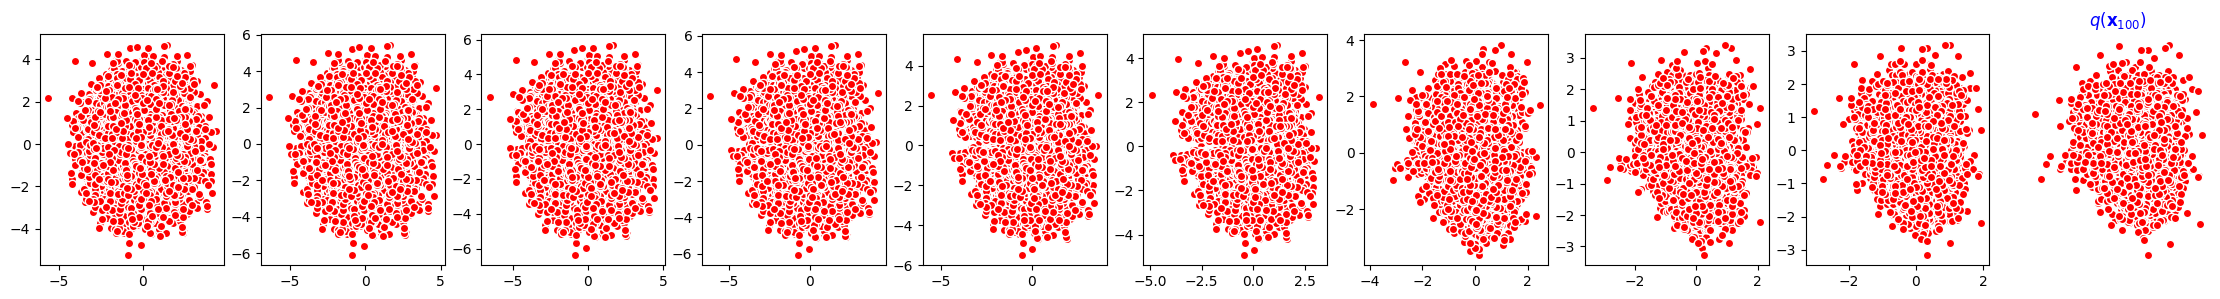

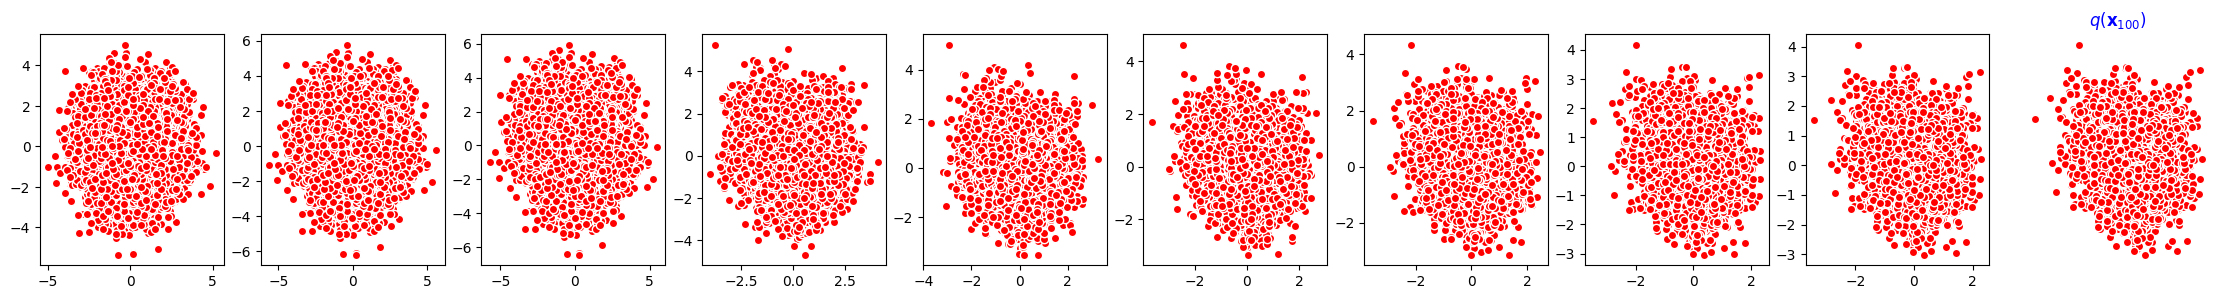

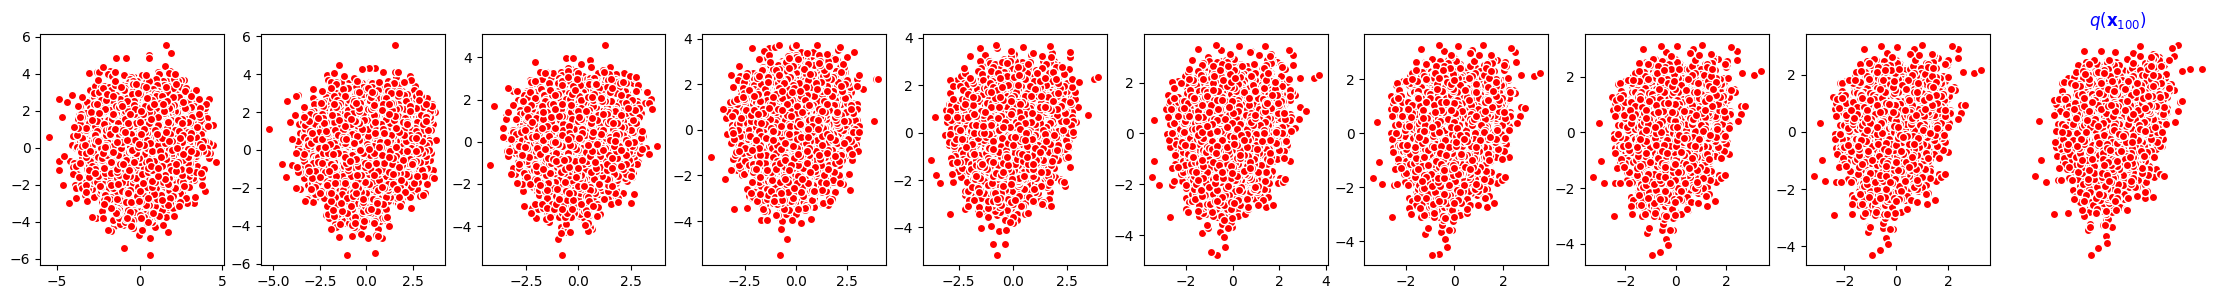

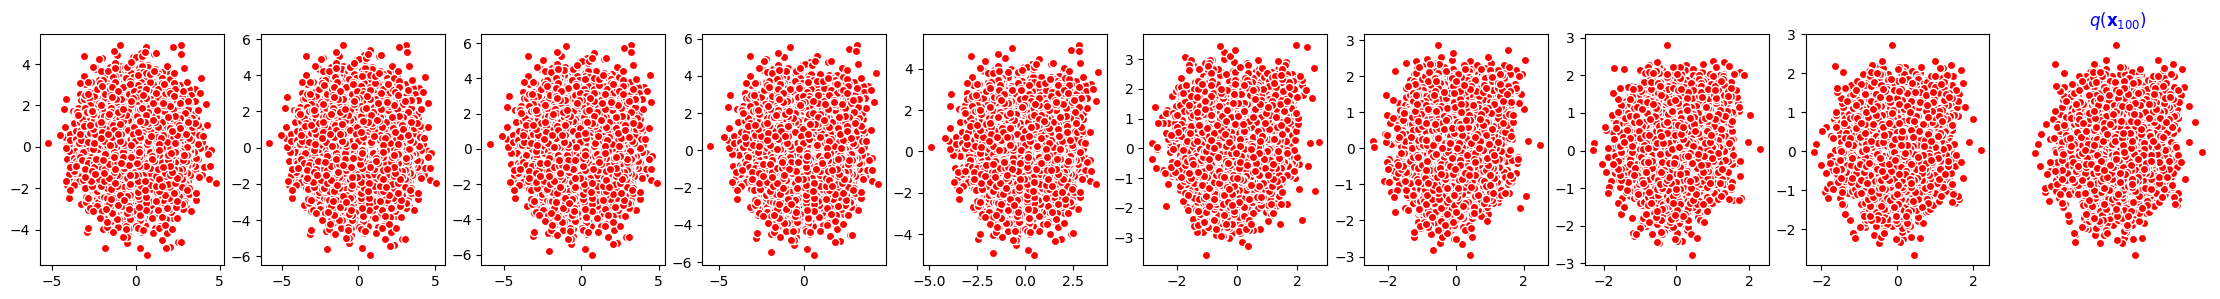

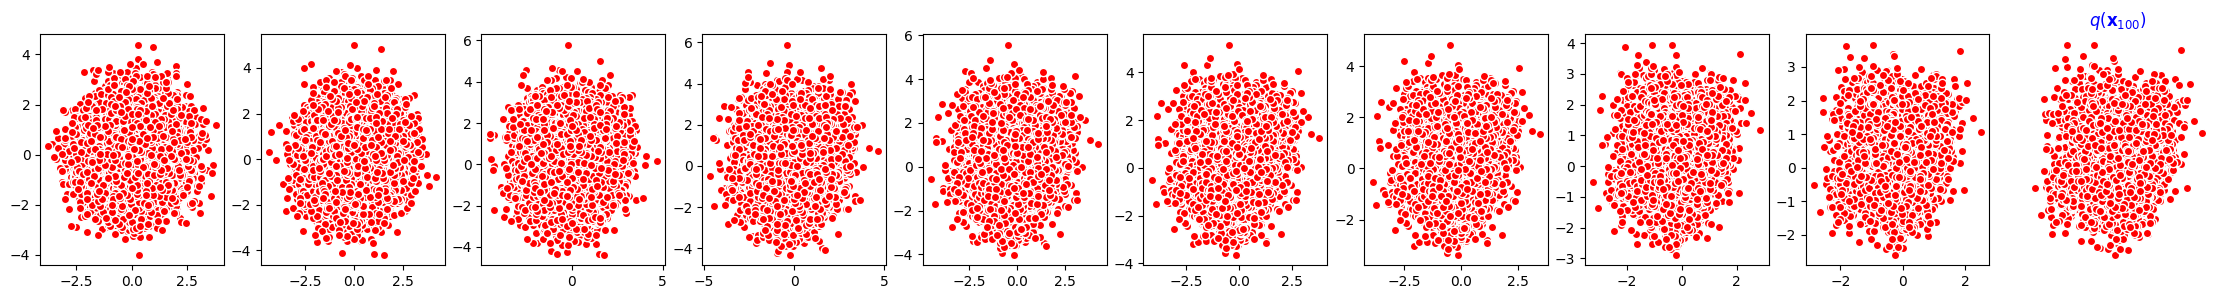

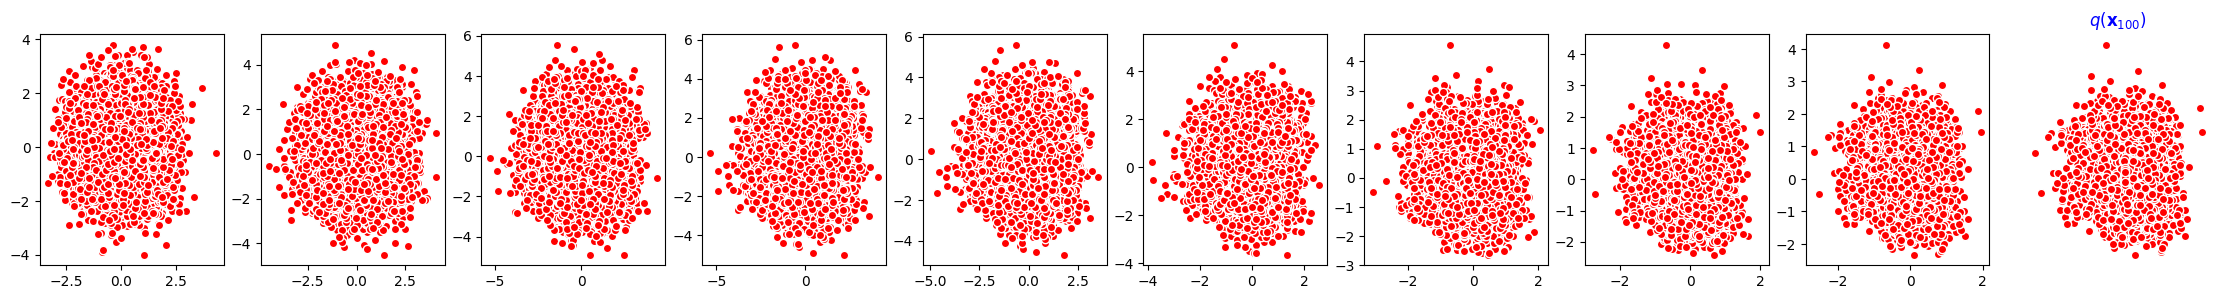

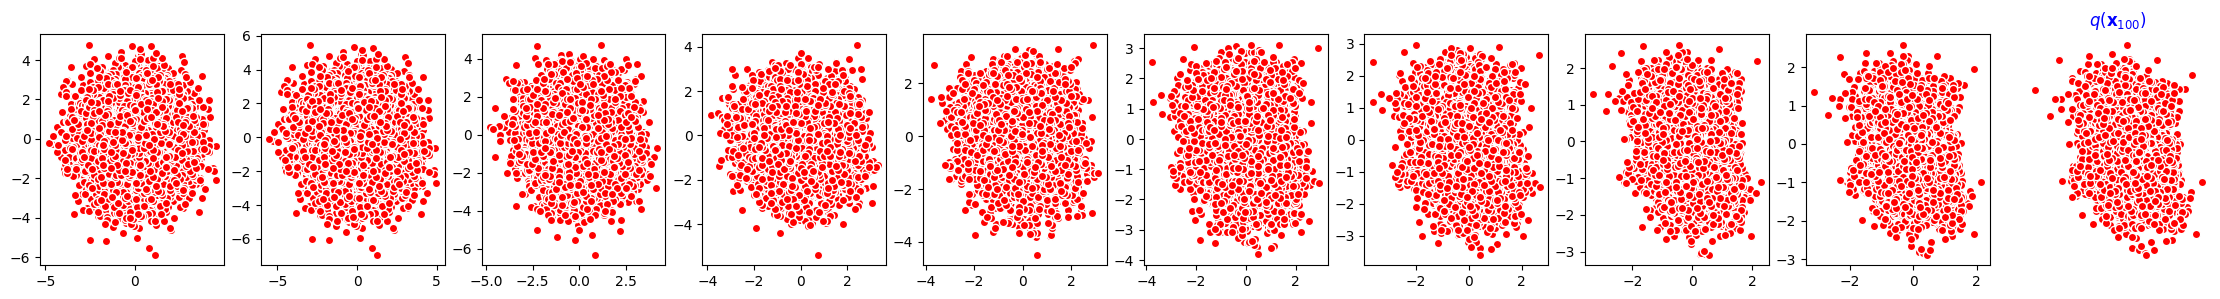

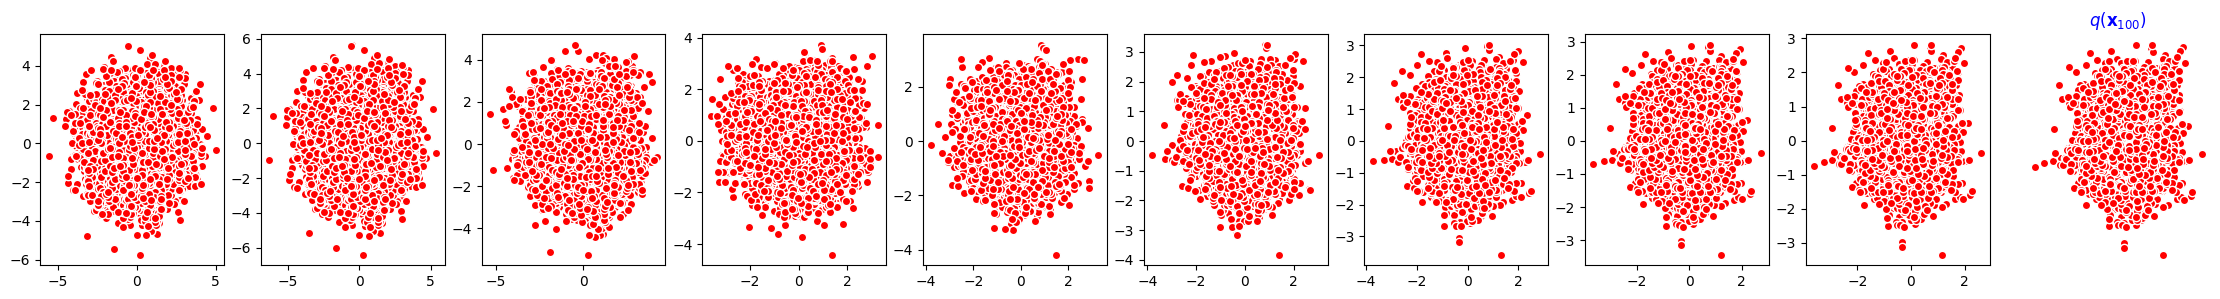

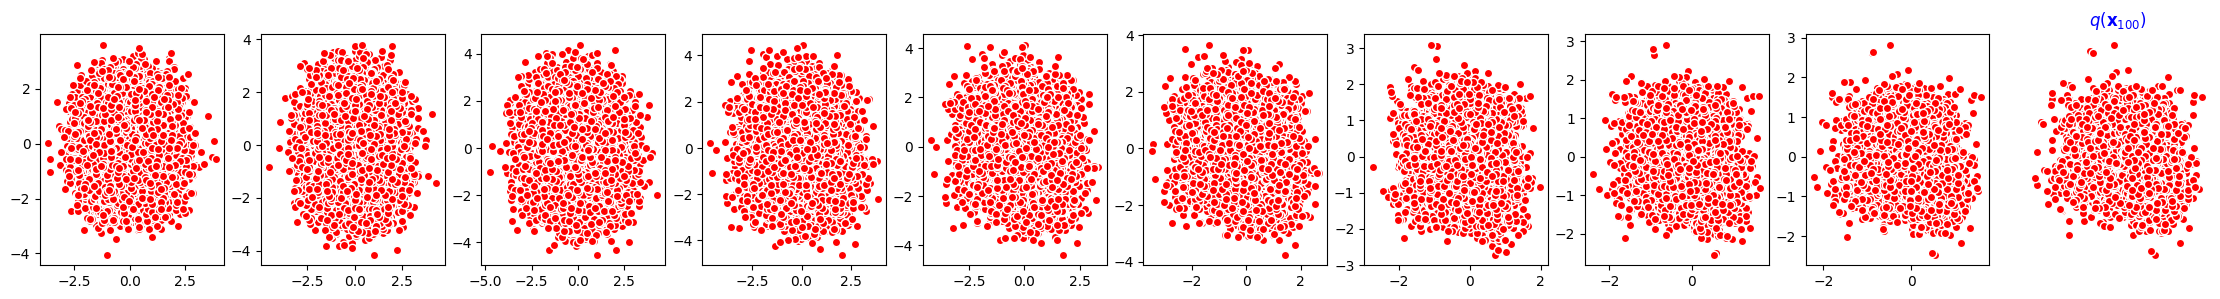

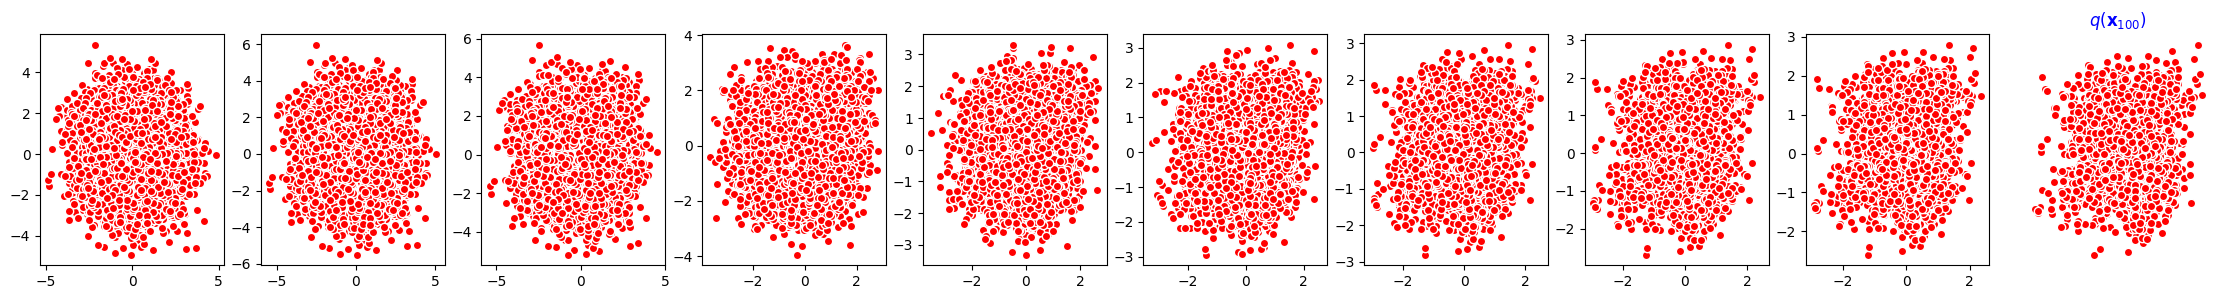

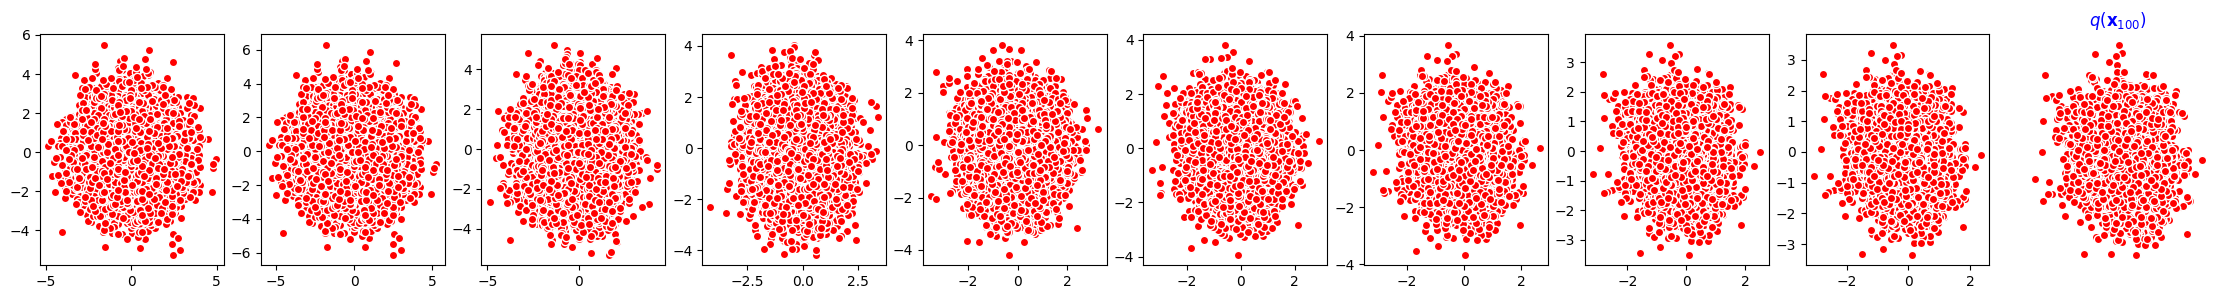

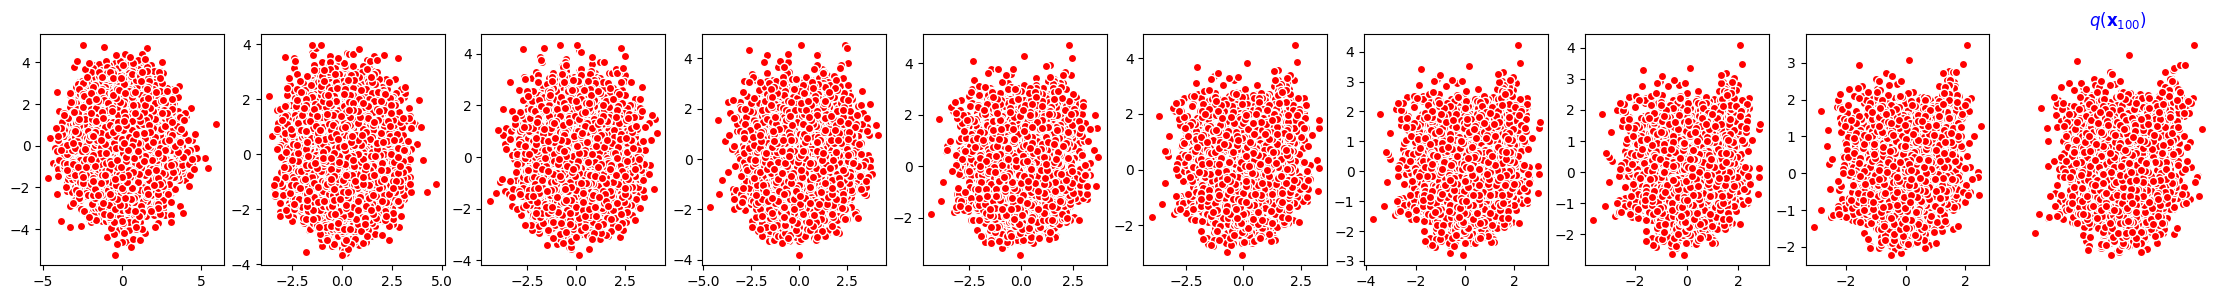

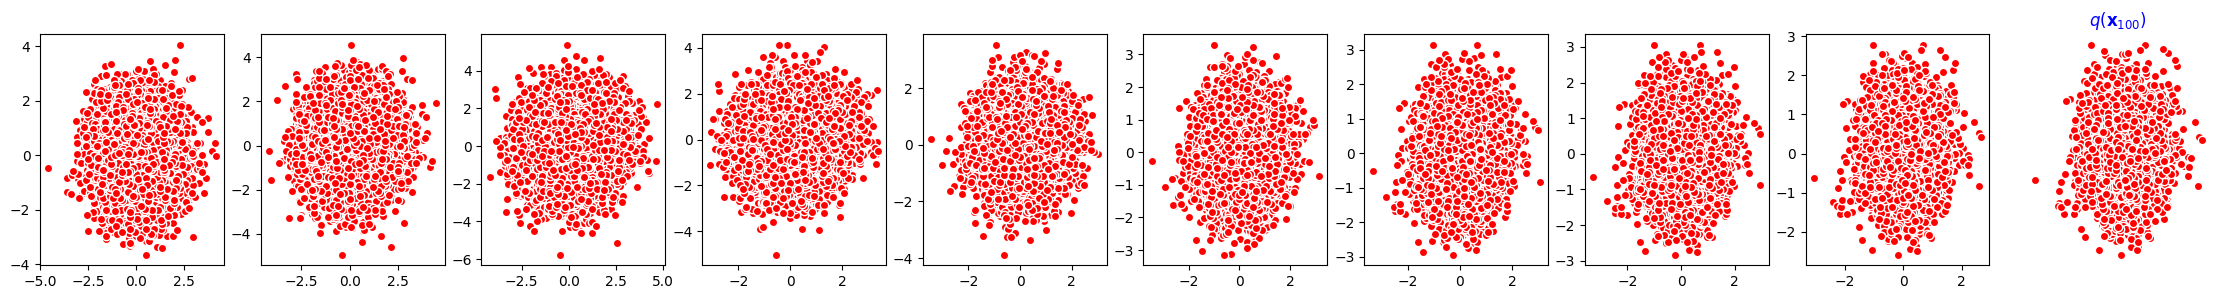

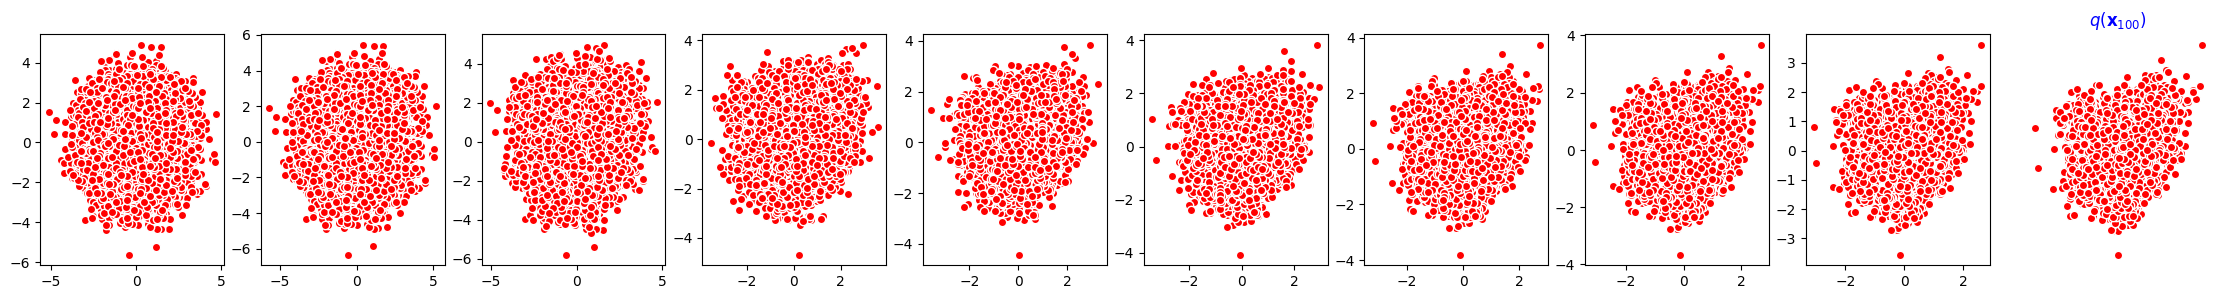

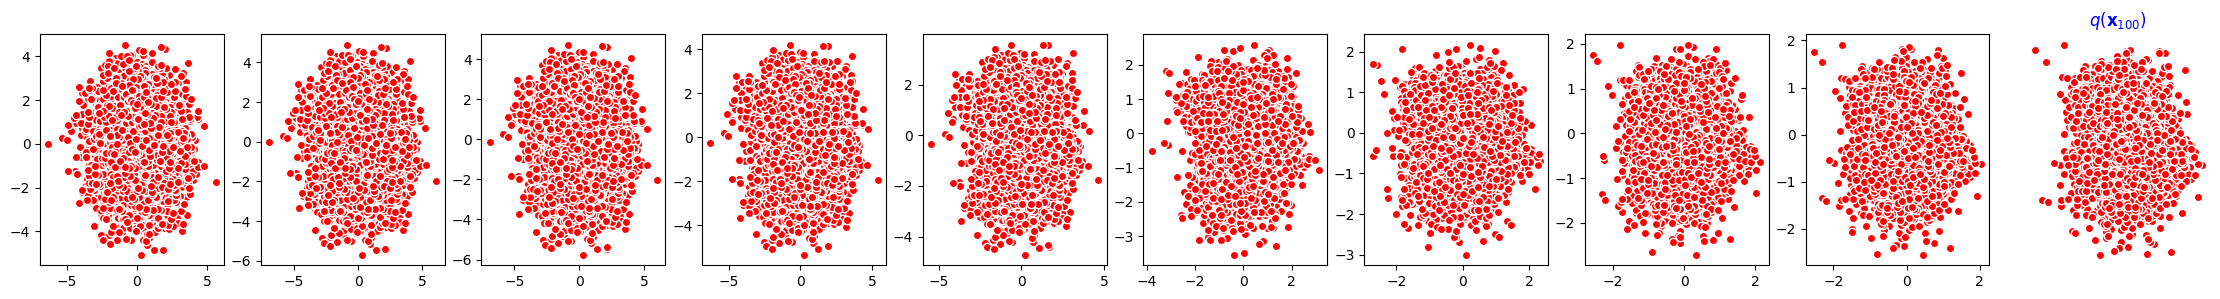

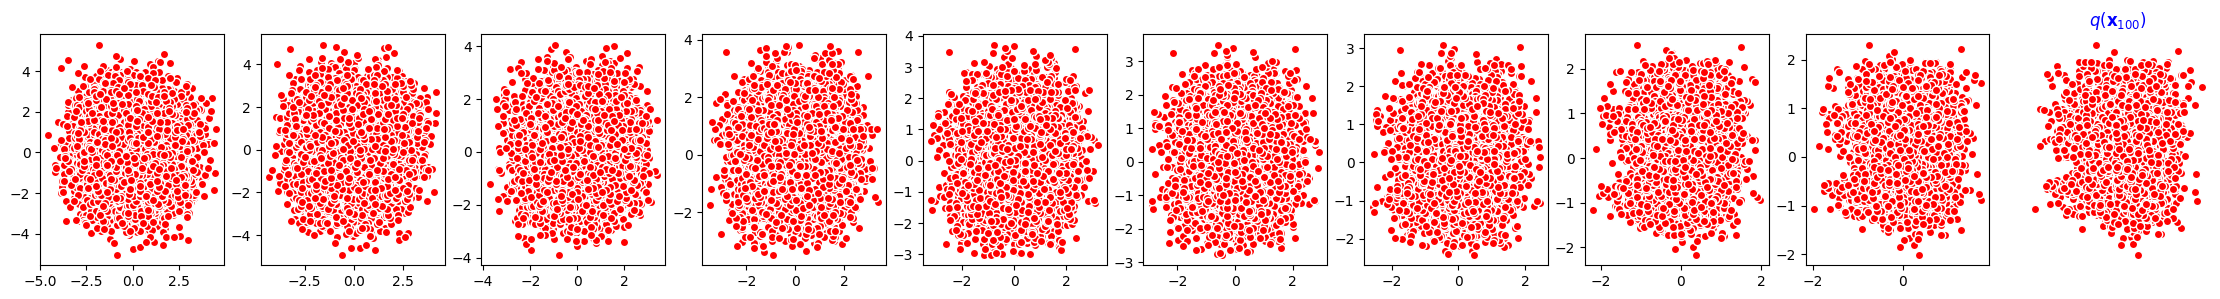

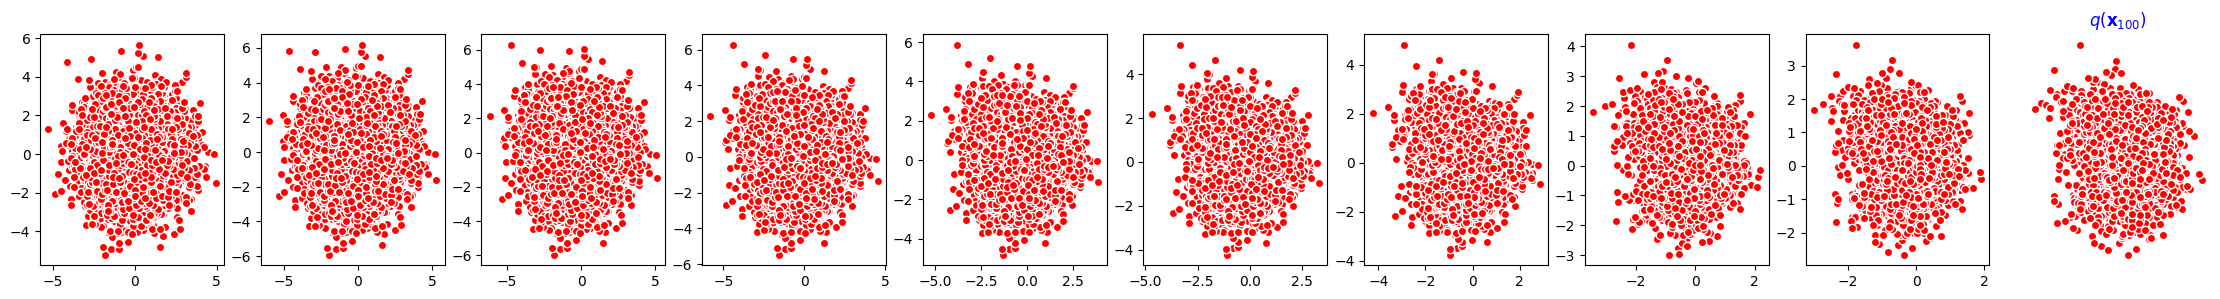

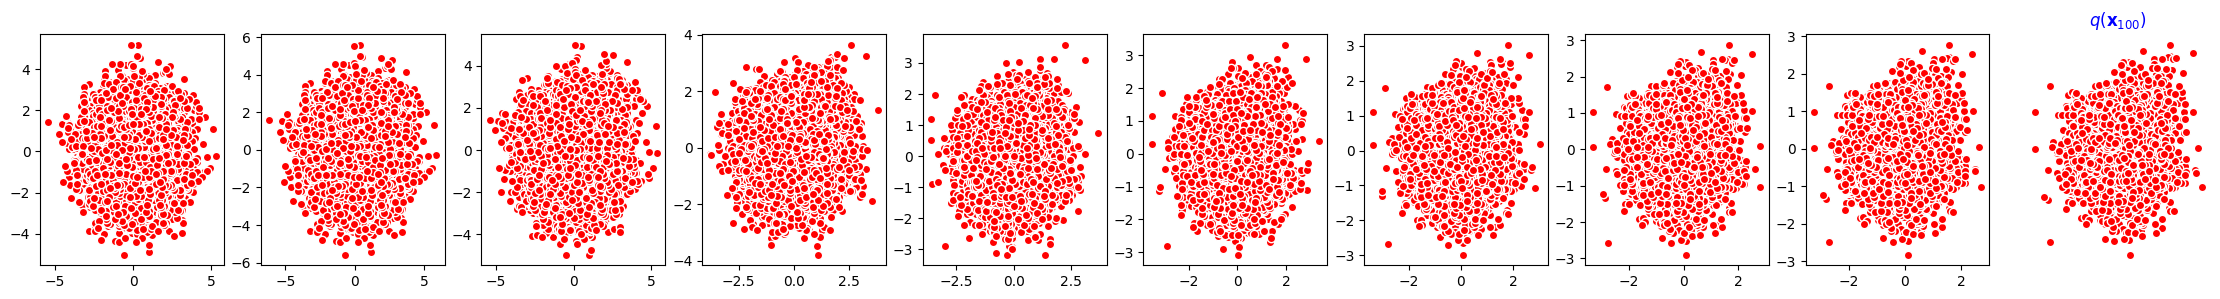

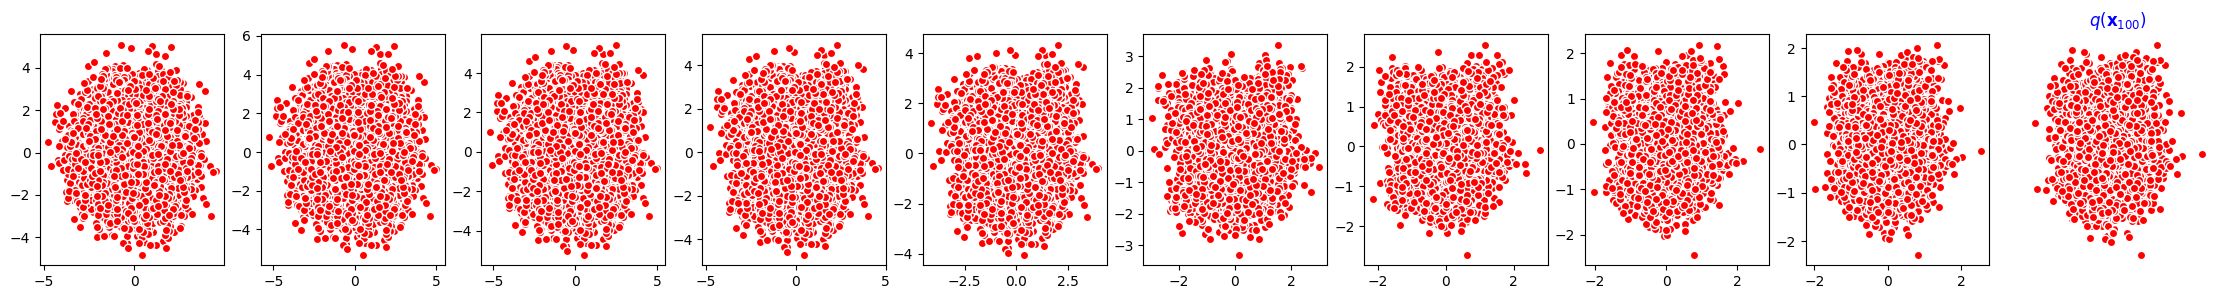

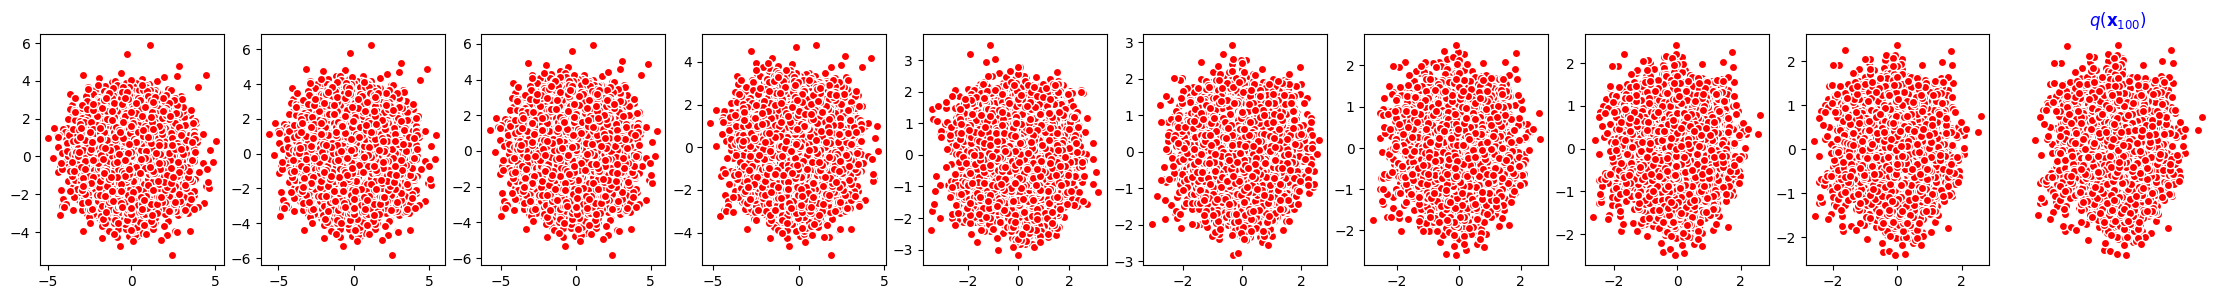

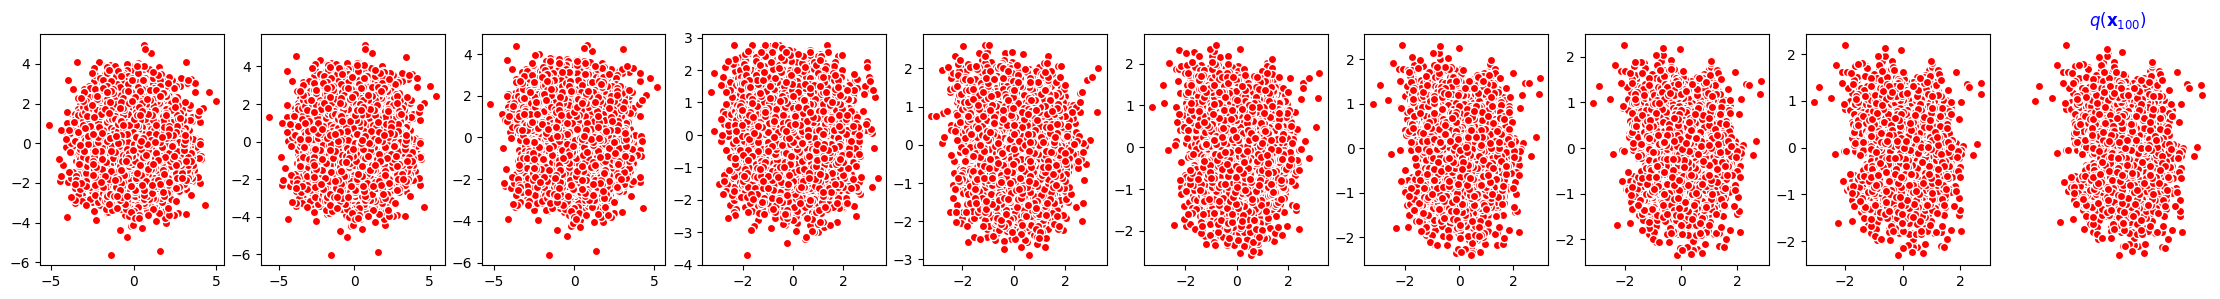

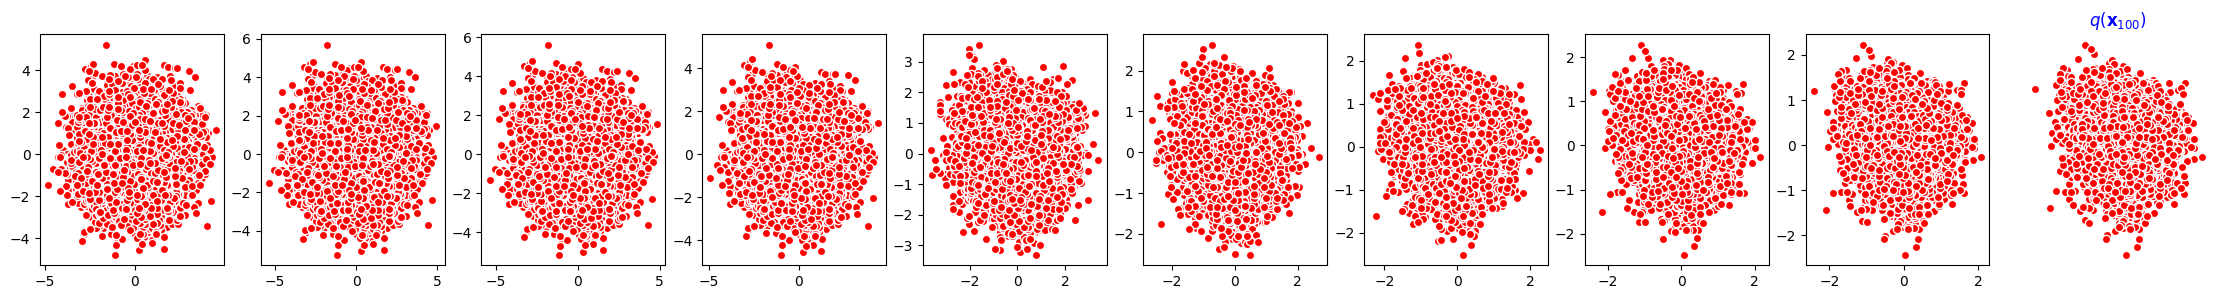

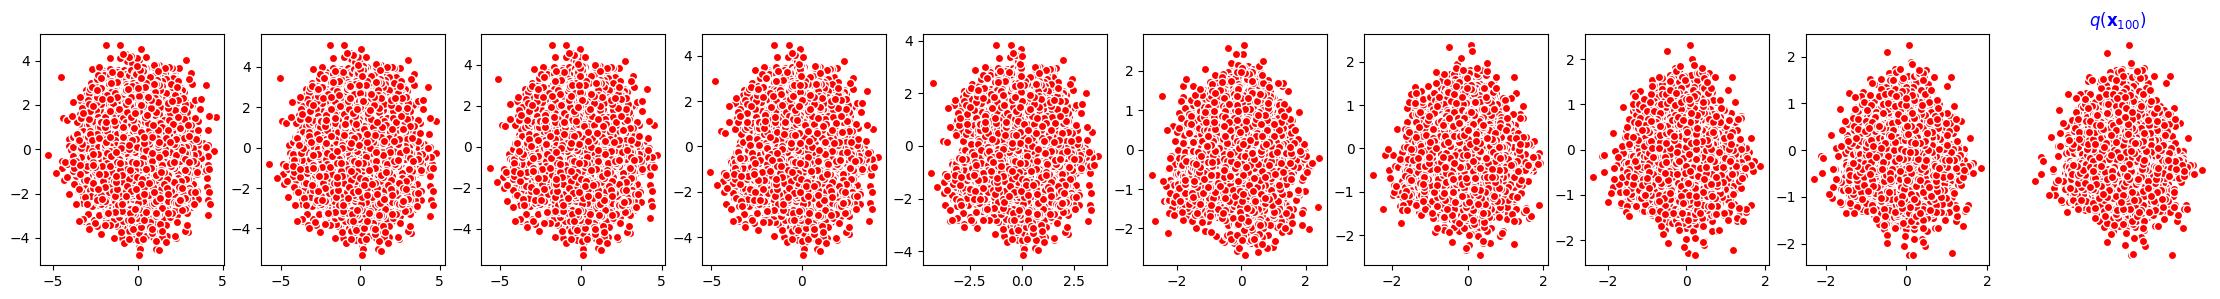

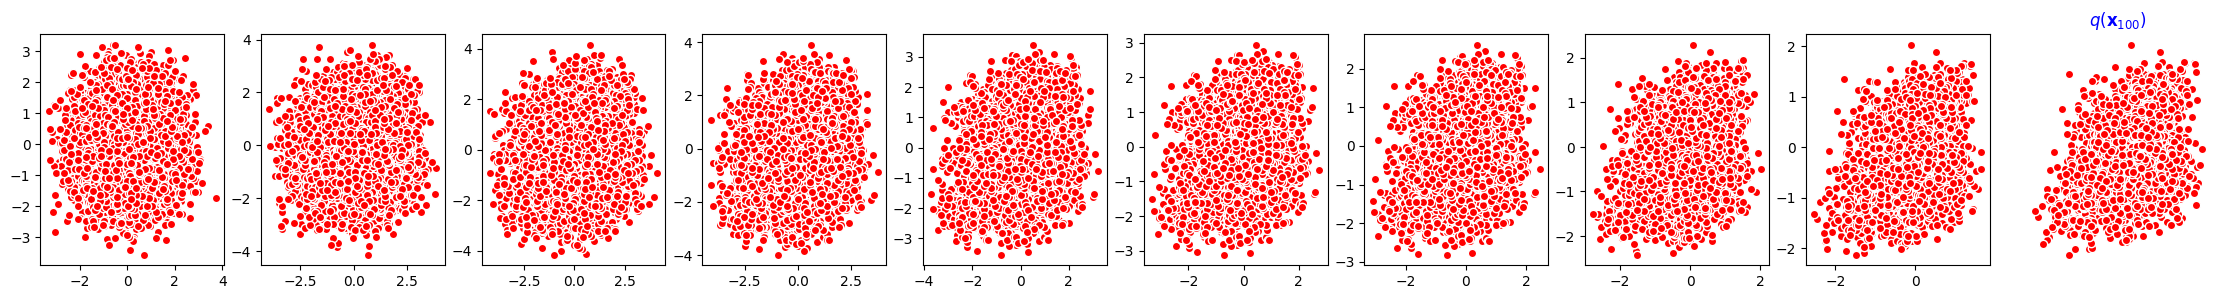

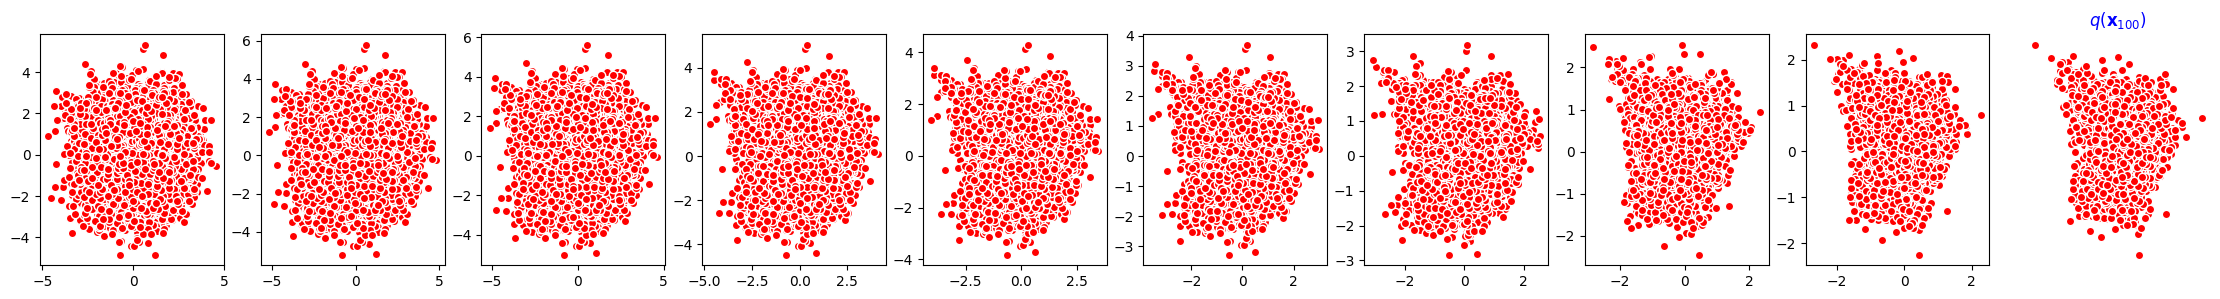

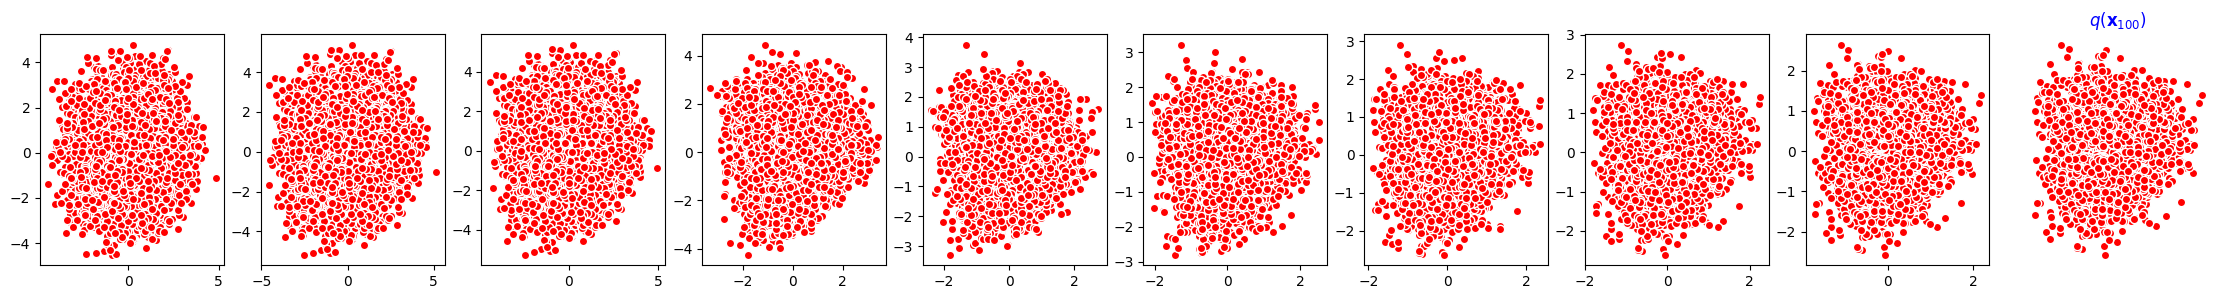

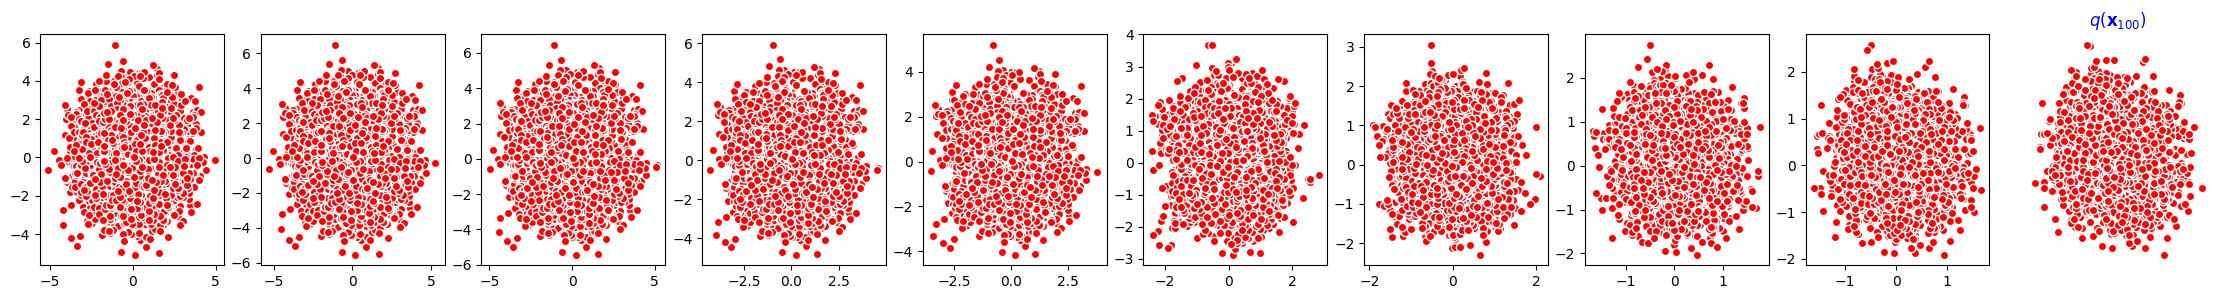

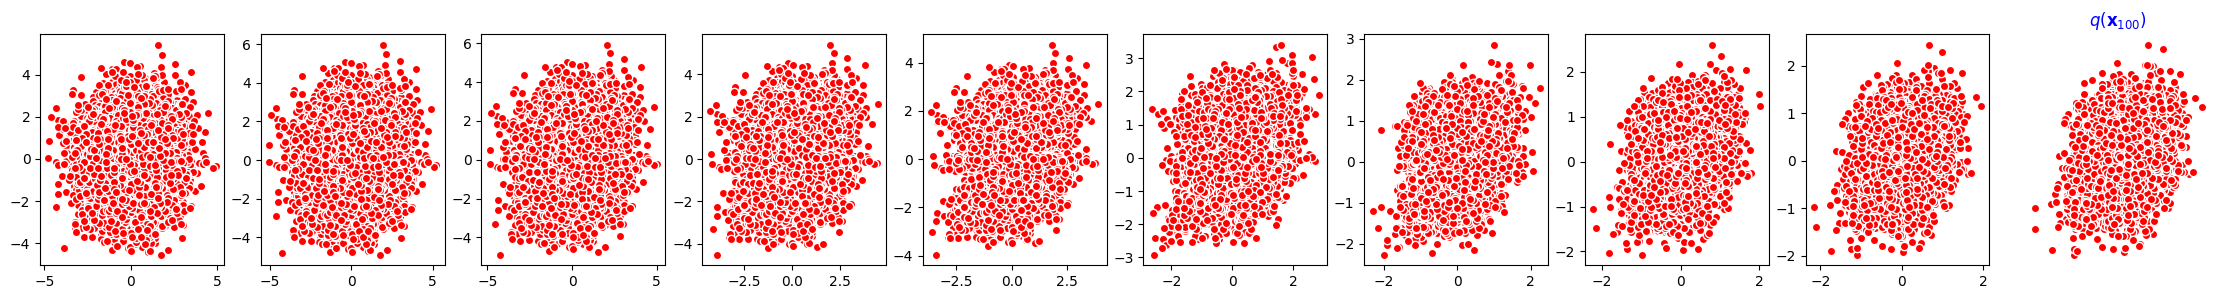

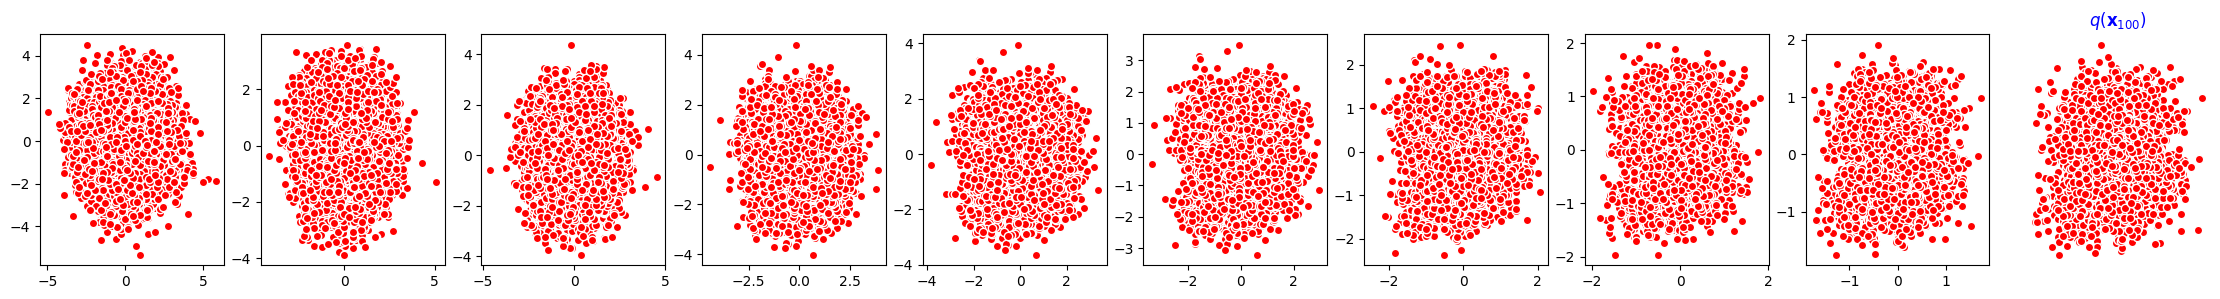

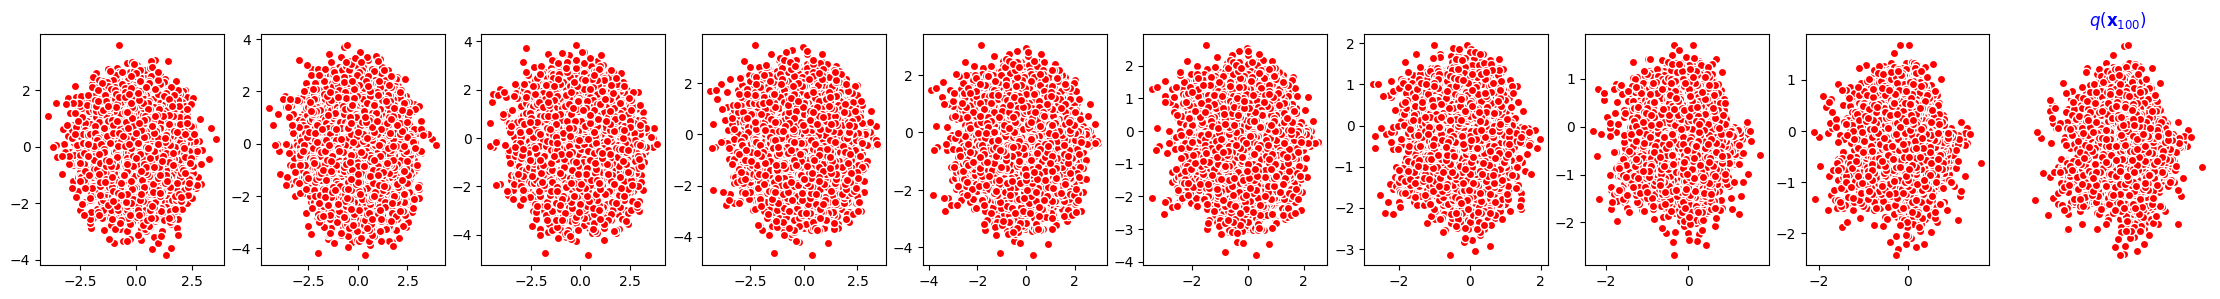

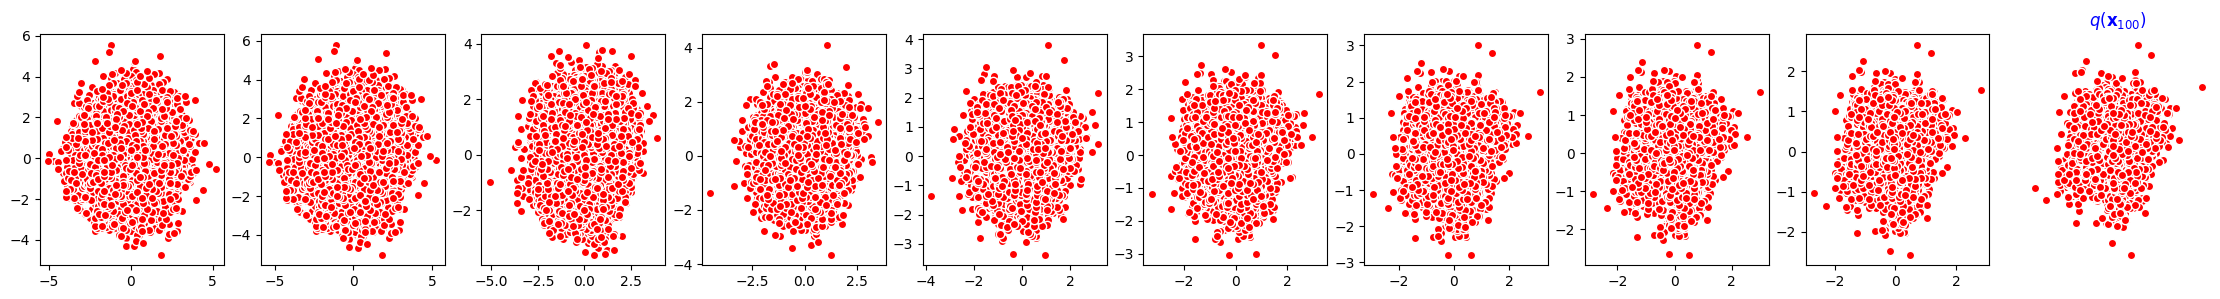

In [19]:
batch_size = 128
dataset_ds = ds.NumpySlicesDataset(data=s_curve, shuffle=True)
dataset_ds = dataset_ds.batch(batch_size)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)
optimizer = ms.nn.Adam(model.trainable_params(), learning_rate=1e-3)
iterator = dataset_ds.create_dict_iterator()


def forward_fn(batch_x):
    return diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)


grad_fn = ms.ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)


def train_step(batch_x):
    loss, grads = grad_fn(batch_x)
    loss = ms.ops.depend(loss, optimizer(grads))
    return loss


model.set_train()

for t in range(num_epoch):
    for idx, batch_x in enumerate(iterator):
        loss = train_step(batch_x['column_0'].astype(ms.float32))

    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))

        for i in range(1, 11):
            cur_x = ms.ops.stop_gradient(x_seq[i * 10])
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[-1].set_axis_off()
            axs[-1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')